In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Audit Report Tracker (Sharepoint List),388.687914,55.526845,88.208677,7
VMWare,605.561416,14.082824,33.705985,43
C# Basics,923.912655,29.803634,75.738152,31
Azure Private DNS,972.400009,51.178948,124.410721,19
Logging in Python,1013.144922,72.367494,220.489522,14
Azure AD Authentication,1114.165247,85.705019,250.535303,13
Azure Functions + Visual Studio,1153.269400,88.713031,192.249574,13
Email Auth and Security,1186.271817,98.855985,255.924935,12
Azure Compute Gallery,1201.746227,30.043656,98.400321,40
RAG Project,1341.325555,83.832847,215.316062,16


# Histogram

sum of ages: ~49322.66


<Axes: >

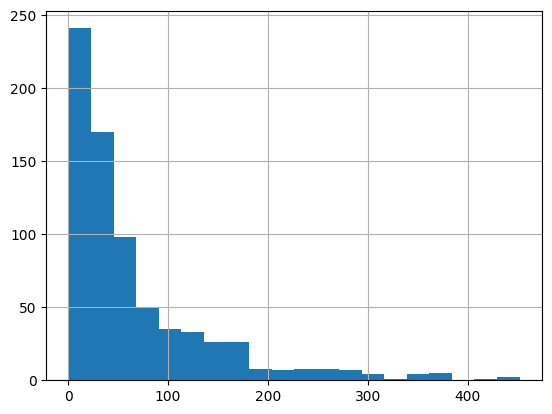

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [25]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [26]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [40]:
existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
remake_card_document(existing_cards)
existing_cards.head(10)

Cards found: 734
Total card age: 49322.66


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
450,JavaScript Concepts,Hot Module Replacement (HMR): A feature in bun...,62eed610b799097eb68b6e656481e34c,451.803113,122.046983,451.803113,6346.443117,0.925888
451,JavaScript Concepts,Spread and Rest Operators (...): Operators tha...,c6d7508de1e7714c70e2314c3435af41,409.577212,122.046983,451.803113,6346.443117,0.925888
452,JavaScript Concepts,Switch Statement\nswitch (expression) {\n c...,640dd8e068d96778d3079d9a38f3175a,381.371308,122.046983,451.803113,6346.443117,0.925888
453,JavaScript Concepts,Async/Await: Syntax for handling asynchronous ...,1cec5db45adcdd9803ca27cafafec52c,372.495093,122.046983,451.803113,6346.443117,0.925888
454,JavaScript Concepts,Dependency Injection: A design pattern used in...,6ce1630383ba0769e21a6141a2968ff6,351.906236,122.046983,451.803113,6346.443117,0.925888
455,JavaScript Concepts,DOM Manipulation: Using JavaScript to select a...,b871c12ad04d13db092c2928c6802edd,349.200640,122.046983,451.803113,6346.443117,0.925888
456,JavaScript Concepts,GraphQL: A query language for APIs that allows...,7e7b34d3208558b7ef2938d10bb39b64,315.936104,122.046983,451.803113,6346.443117,0.925888
457,JavaScript Concepts,Parcel: A zero-configuration bundler that auto...,8853aee1ab1aab7096a1a8e936fedec1,289.271110,122.046983,451.803113,6346.443117,0.925888
458,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,271.253599,122.046983,451.803113,6346.443117,0.925888
459,JavaScript Concepts,Lazy Loading: Deferring the loading of non-cri...,b2d7160e58720a8441c71f99cb8fcec5,255.132905,122.046983,451.803113,6346.443117,0.925888


## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [30]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [31]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [32]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [33]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [34]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [35]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [36]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [37]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
621,Azure Developer Associate,What's the recommended authentication method f...,92c7baf1544a3d6d4ced3a3057810fec,0.443582,80.889731,308.928492,4934.273578,0.582593
622,Azure Developer Associate,You can pull container images from Azure Conta...,d3c3fa54b8227ecfb15e18b69bf5afa3,0.595427,80.889731,308.928492,4934.273578,0.582593
616,Azure Developer Associate,Geo-replication enables a container registry t...,bc0e2da023ab89eb21878030f1e01e8a,1.772756,80.889731,308.928492,4934.273578,0.582593
619,Azure Developer Associate,Type of Azure Container Registry authenticatio...,479458e1b339f5153c380c9b5d3d9922,2.484172,80.889731,308.928492,4934.273578,0.582593
613,Azure Developer Associate,Let's say you have compute workloads deployed ...,ac85c9e8d85ce50be39201db139bc927,2.677990,80.889731,308.928492,4934.273578,0.582593
728,Vocab,"Something Rotten, Fforde\nTimpet\nnoun | TIM-p...",cdaef1f8166f9351b220c1f851ffde58,2.932841,52.651609,303.916360,5844.328561,0.970830
614,Azure Developer Associate,Make sure you add the period (.) to the end of...,dcd2a6970dcd4fd13e31426277eccd8b,3.119784,80.889731,308.928492,4934.273578,0.582593
615,Azure Developer Associate,Geo-replication enables a container registry t...,339c20d5e16e08f63569052309b38f5e,3.230323,80.889731,308.928492,4934.273578,0.582593
727,Vocab,"Something Rotten, Fforde\nThylacine\nnoun | TH...",755d01fe4fbce3e79bc958b29f734803,3.269011,52.651609,303.916360,5844.328561,0.970830
617,Azure Developer Associate,Benefits to using Azure Container Registry:\n ...,28bfea4abe4c6d17701b3a5c89e17b7d,3.449835,80.889731,308.928492,4934.273578,0.582593


In [38]:
existing_cards.head(10).sum()

head                   JavaScript ConceptsJavaScript ConceptsJavaScri...
body                   Hot Module Replacement (HMR): A feature in bun...
hash                   62eed610b799097eb68b6e656481e34cc6d7508de1e771...
age                                                           3447.94732
subject_mean_age                                              1220.46983
subject_highest_age                                          4518.031133
subject_age_sum                                             63464.431173
head_random_roll                                                9.258875
dtype: object

In [39]:
existing_cards['age'].mean()

67.19708650545154